In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# emg file directory & path

emg_rock_short_path = "./myo/myo_emg_data(short_frequently_lock).txt"

In [3]:
# load Strongly Short Power emg data

sensor_channels = 8
short_emgs = [list() for i in range(sensor_channels)]

with open(emg_rock_short_path) as f:
    while(1):                
        line = f.readline().rstrip()
        line = line.replace(" ", "")
        if (line is None or line == ""):
            break
        
        #print(line)        
        _emgs = line.split("\t")                
        
        for i in range(sensor_channels):
            short_emgs[i].append(int(_emgs[i]))            

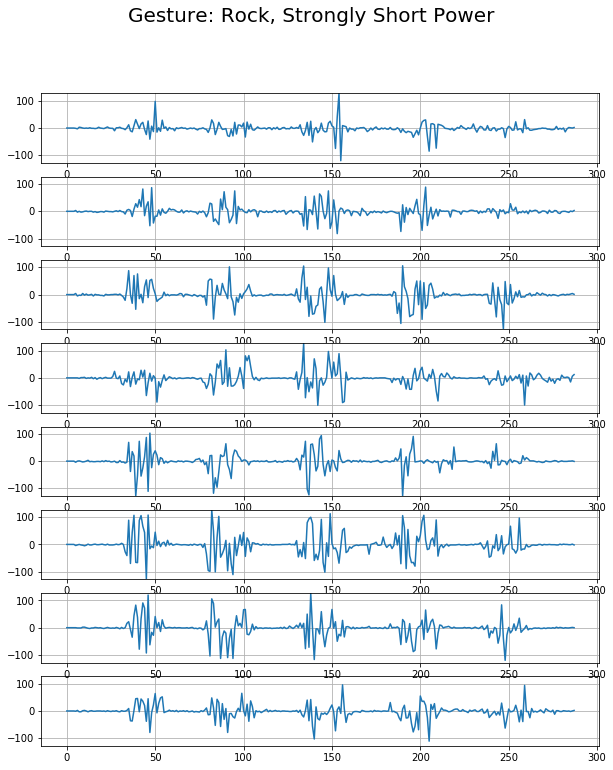

In [4]:
fig = plt.figure(figsize=(10,12))
fig.suptitle("Gesture: Rock, Strongly Short Power", fontsize=20)

for i in range(sensor_channels):
    arg = "81" + str(i)
    plt.subplot(arg)
    plt.plot(short_emgs[i])
    plt.grid()
    plt.ylim([-128, 127])


plt.show()

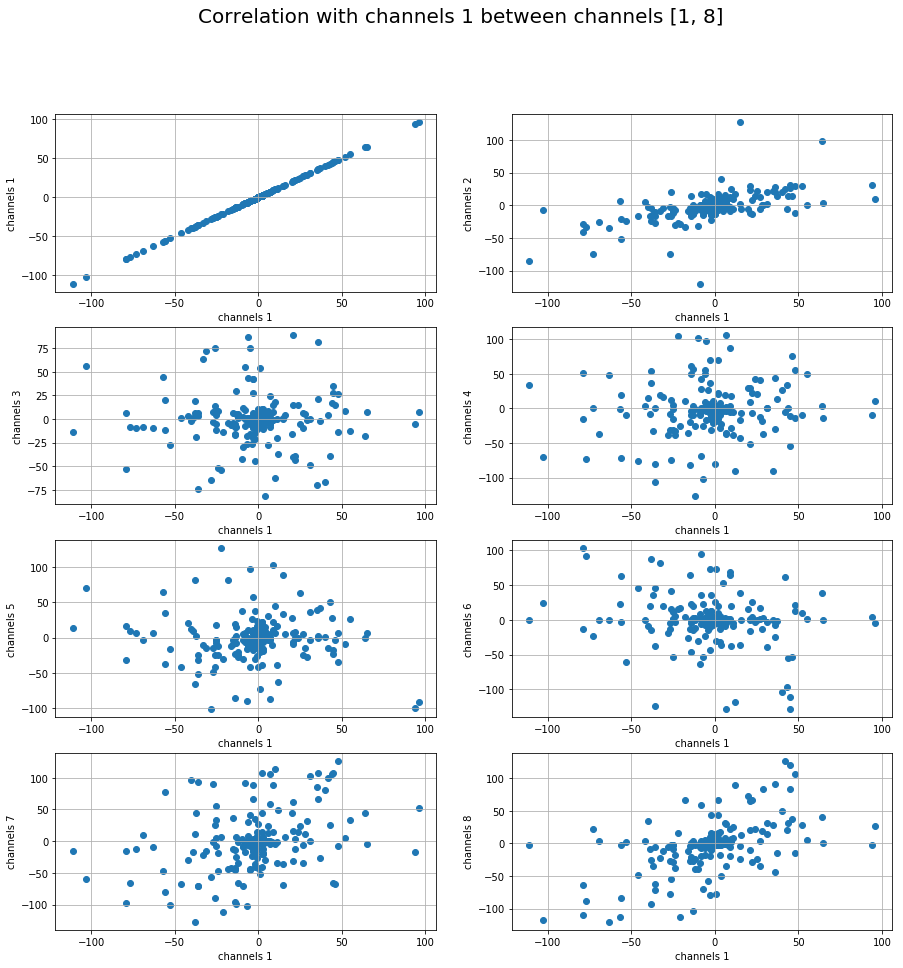

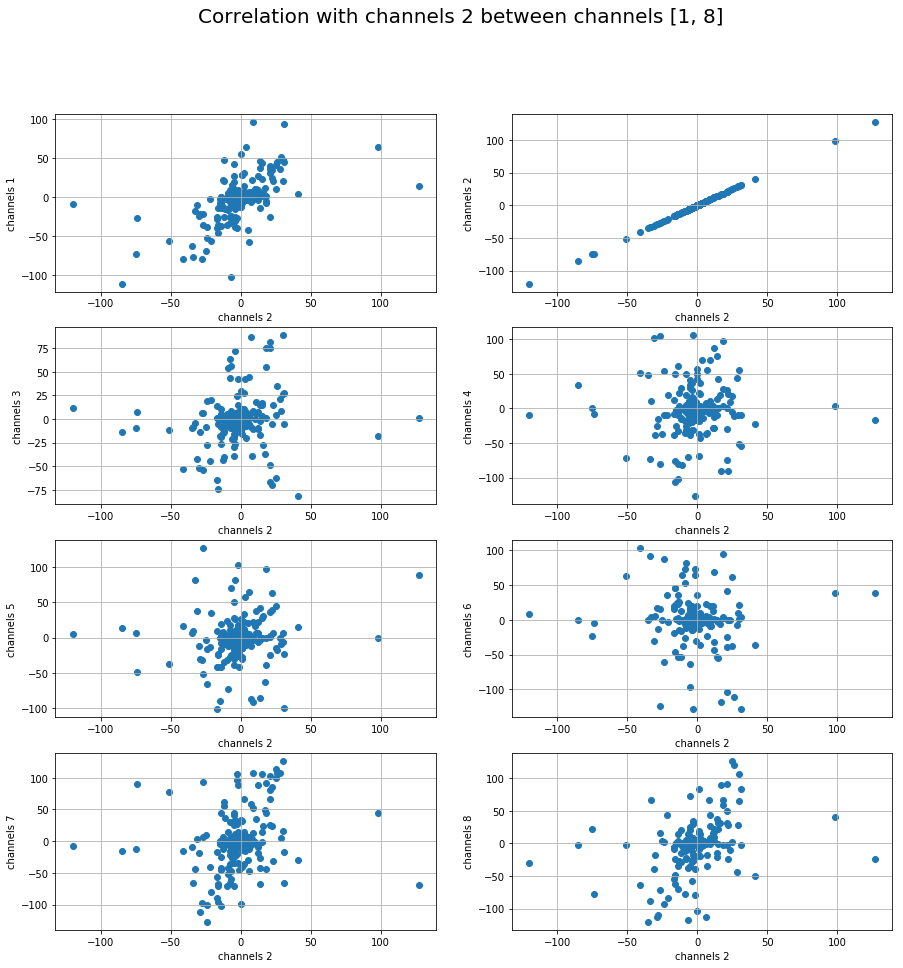

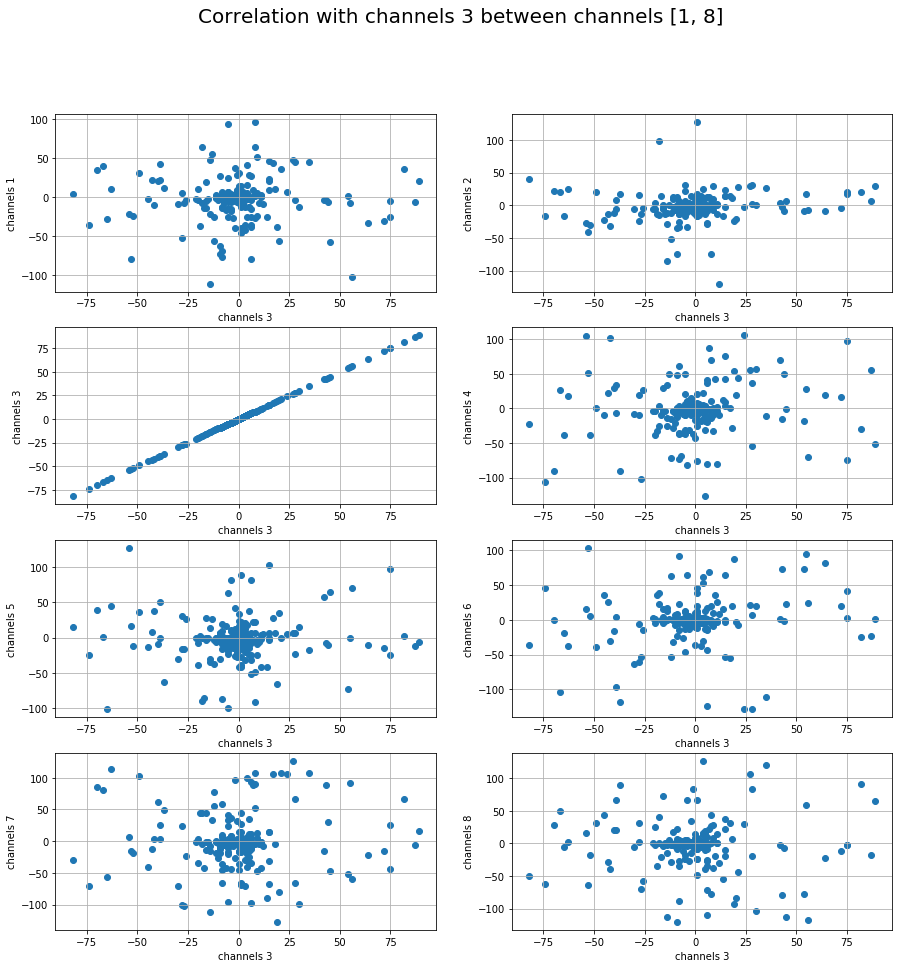

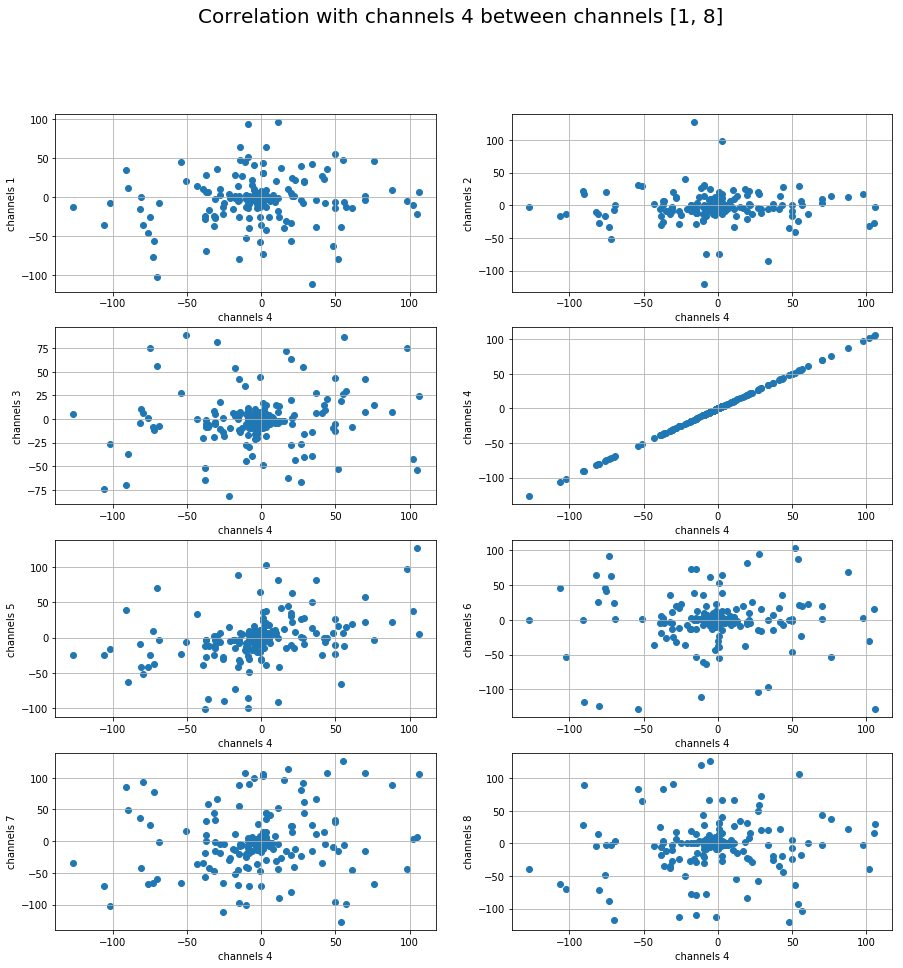

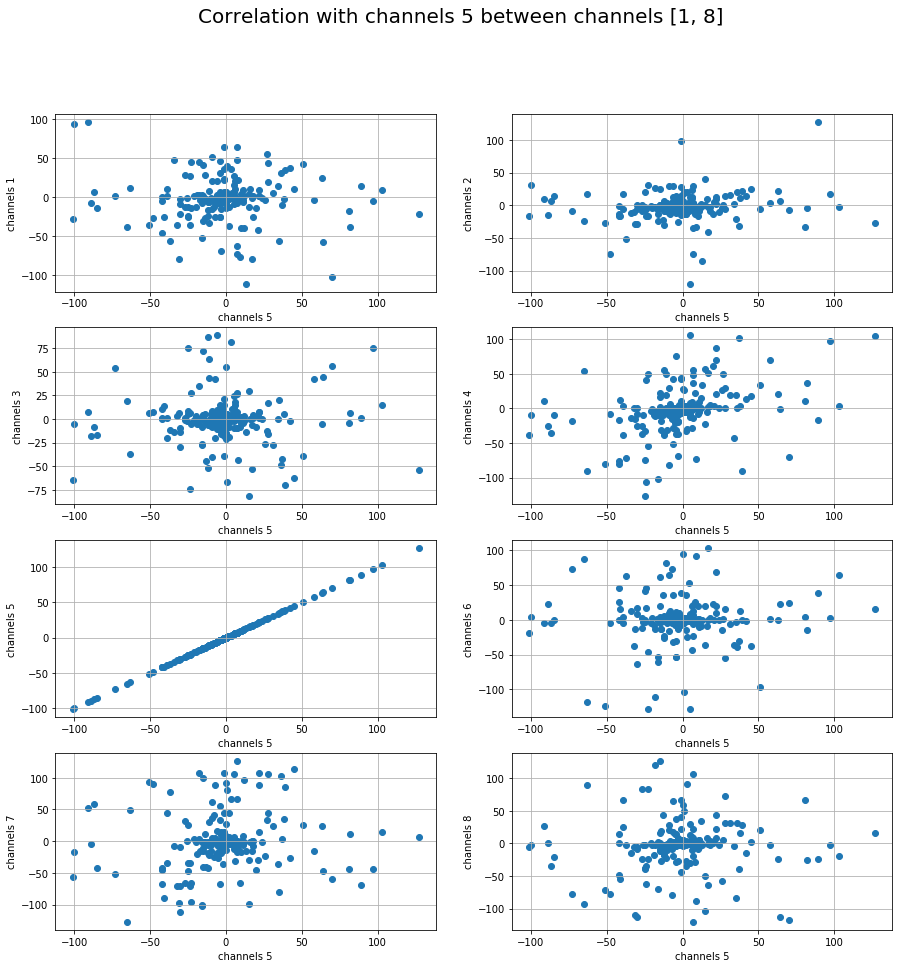

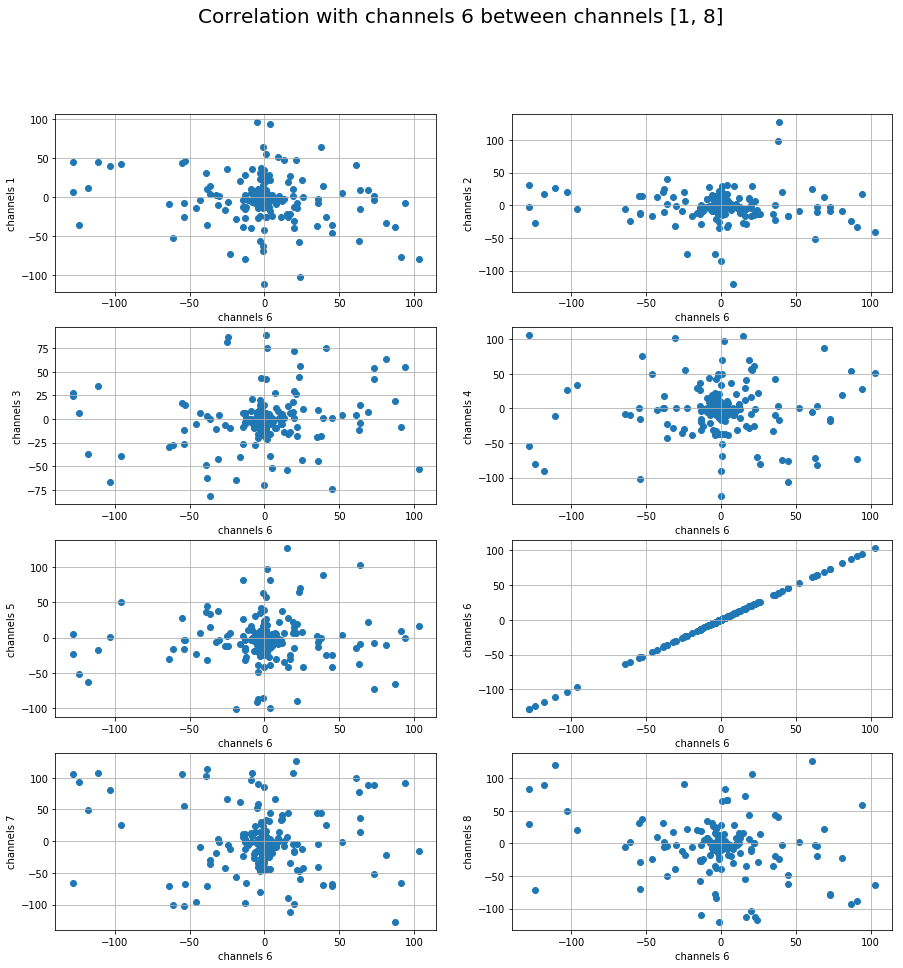

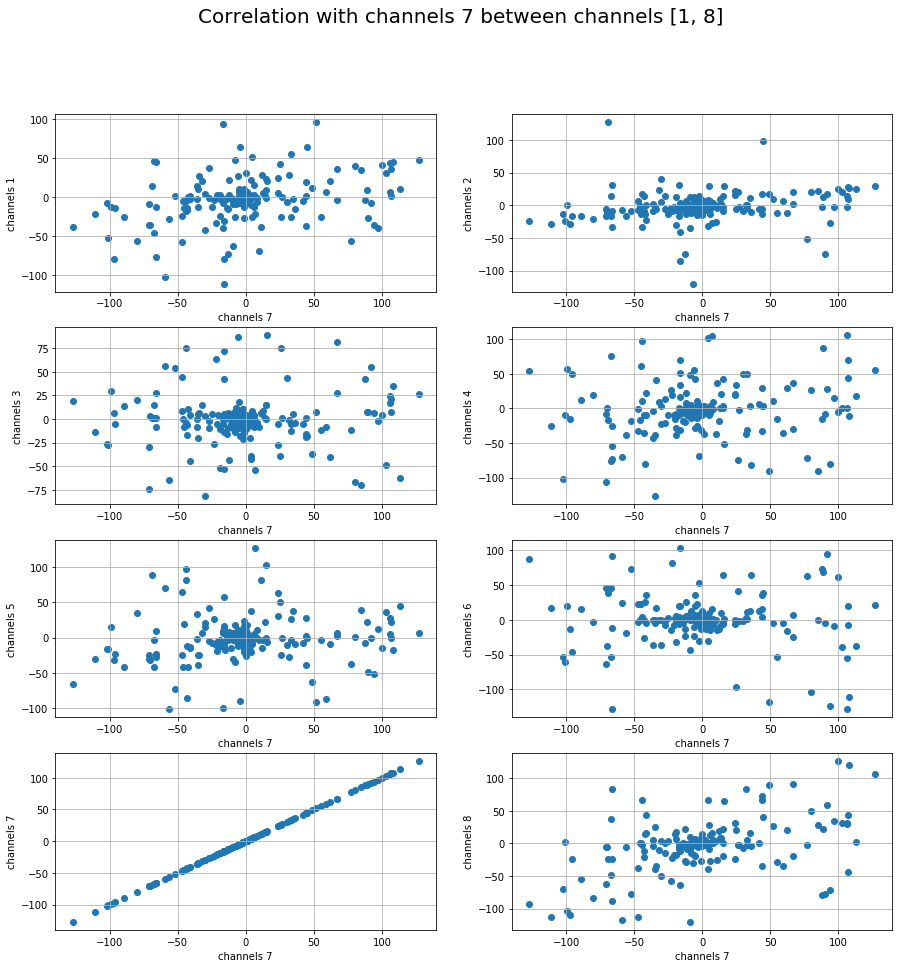

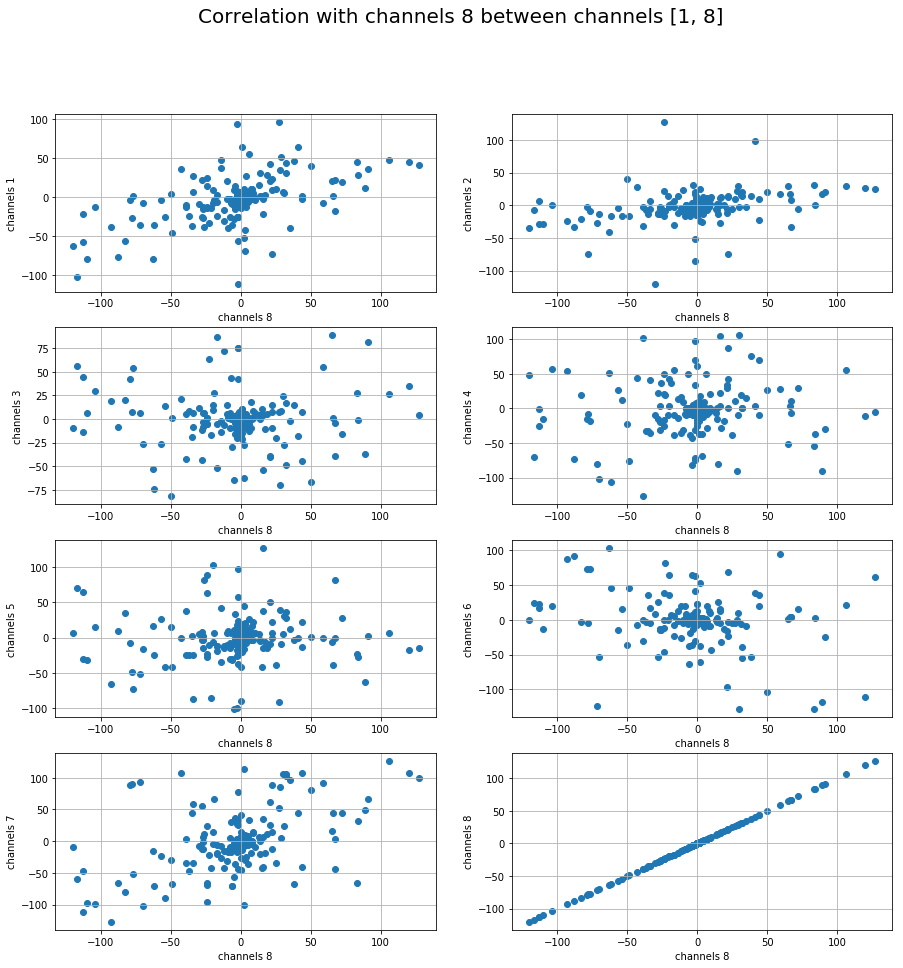

In [5]:
# scatter plot of channels 1 between channels 8
for i in range(sensor_channels):
    fig = plt.figure(figsize=(15,15))
    fig.suptitle("Correlation with channels {} between channels [1, 8]".format(i+1), fontsize=20)

    for j in range(sensor_channels):
        arg = "42" + str(j+1)
        plt.subplot(arg)    
        plt.scatter(short_emgs[i], short_emgs[j])
        plt.xlabel("channels {}".format(i+1))
        plt.ylabel("channels {}".format(j+1))
        plt.grid()
    plt.show()

# [Nonlinear multivariate analysis of Neurophysiological Signals](https://www.researchgate.net/publication/7478280_Nonlinear_multivariate_analysis_of_Neurophysiological_Signals)

필요하다면 논문 참조할 것.  

## 4. Nonlinear correlation coefficient

- 해당 측정(measure)는 비모수 비선형 회귀 계수(nonparametric nonlinear regression coefficient)
    - $X$에 대한 $Y$의 의존성을 가장 일반적인 방식으로 나타낸다.
    > Lopes da Silva et al., 1989; Pijn et al., 1990    

<br/>

- 기본 아이디어는 $X$의 값이 $Y$의 값의 함수로 간주할 수 있으면, 주어진 $Y$의 값을 비선형 회귀 곡선(regression curve)에 따라 예측할 수 있다.
    - $Y$값이 $X$를 입력으로 받는 어떠한 함수 $f$의 출력값으로 간주된다는 이야기
    - $Y = f(X)$  

<br/>

- 회귀 곡선(regression curve)에 따른 $Y$의 분산(variance)는 $X$로 인해 설명되거나, 예측될 수 있기 때문에 설명된 분산(explained variance)라고 함
- 설명되지 않은 분산(unexplained variance)는 설명된 분산(explained variance)에서 원래의 분산를 빼서 추정할 수 있다.  
    
- 상관관계 비율(correlation ratio) $\eta^{2}$는 $Y$의 분산에 대한 감소에 대해서 설명하는 인덱스다.
    - 여기서 $Y$는 $f(X)$를 통해서 얻을 수 있다.
    - $\eta^{2} = \frac{(total\ variance\ -\ unexplained variance)}{total\ variance}$  

<br/>

- 연산은 비선형 회귀 단계를 포함하고 있다.
- 따라서 유한한 데이터 포인트를 갖는 두개의 신호 사이에서만 상관비율을 추정할 수 있다.
- 앞서 이야기한 비율측정에 대한 추정은 비선형상관계수 혹은 비선형회귀계수 $h^{2}$라고 불린다.(non-linear correlation coefficient $h^{2}$)  

<br/>   

- 실제로는 $Y$와 $X$에 대한 산점도를 이용해서 연구를 진행하게된다.
- 먼저 $X$의 값들을 bin으로 세분화한다.
- 각 bin에 대해서 중간 점($p_{i}$)의 $X$값과 $Y$($q_{i}$)의 평균값을 계산한다.
- 회귀 곡선(regression curve)는 결과 포인트 ($p_{i}, q_{i}$)를 직선 세그먼트(line segment)로 연결해서 근사화한다.  

<br/>          

- 변형된 신호 $X$와 $Y$ 사이의 non-linear correlation coefficient는 아래와 같이 계산할 수 있다.  

$$ h^{2}_{y|x} = \frac{\sum_{k=1}^{N} y(k)^{2} - \sum_{k=1}^{N}(y(k) - f(x_{i}))^{2}}{\sum_{k=1}^{N}y(k)^{2}}$$  

> 여기서 $f(x_{i})$는 비선형 회귀 곡선(non-linear regression curve)의 선형 조각별 근사(linear piecewise approximation)이다.  

<br/>

- 반대 방향 $h^{2}_{x|y}$는 유사하게 구할 수 있다.

### Method

내가 해석한 내용을 순차적으로 풀어봄

- 일단 x축을 특정 개수의 bin으로 나눔
    - 여기서 bin은 x축 기점으로만 나눔.
    - y축은 bin을 나누지 않음  
  
<br/>
  
- 이제 각 bin마다 x축의 범위 [n, m]이 존재함
    - x축 범위에 대응하는 y축의 값들도 존재함
    
<br/>

- 각 bin에서 x축의 중간값을 정함. 
$$p_{i} = \frac{m-n}{2}$$
- 각 bin에서 y축의 중간값을 정함. 
$$q_{i} = \frac{1}{m-n}\sum_{k=m}^{N=n}{f(x_{k})}$$

<br>

### Approach

- bin을 32개로 나눔 (data quantization level is $[-128, 127]$, range of x axis is $[n, n+8]$)
- 채널 1과 나머지 채널(1~8)사이의 비선형 회귀곡선(non-linear regression curve)을 그림

In [11]:
class linearPiecewiseApproximationFn:
    def __init__(self, fnlist: list, nodes: list):
        self.fnlist = fnlist
        self.nodes = nodes
        
    def __call__(self, x):
        # validate range of x
        # TODO
        # can not handling numpy array or list.
        fn = self.select_fn(x)
        return fn(x)
    
    def select_fn(self, x):
        for i in range(len(self.nodes)):
            extent = self.nodes[i]
            flag = (extent[0]<= x and x < extent[-1])
            if flag:
                return self.fnlist[i]

class linearFn:
    def __init__(self, coefficient:float, bias:float):
        self.coefficient = coefficient
        self.bias = bias
        
    def __call__(self, x):
        return self.coefficient * x + self.bias

def get_nonlinear_regression_curve(bins : list) -> list:
    # linear piecewise approximation of the nonlinear regression curve
    # return has multiple linear function that establish only specific range like a bins
    
    # refer here <https://optimization.mccormick.northwestern.edu/index.php/Piecewise_linear_approximation>
        
    # get coordinate nodes for make linear function
    coordinates = list()
    nodes = list()
    for _bin in bins:        
        range_of_x = _bin['x']
        nodes.append(_bin['x'].tolist())
        values_of_y = _bin['y']
        
        p_i = range_of_x[-1] + (range_of_x[-1] - range_of_x[0])
        q_i = np.sum(values_of_y) / values_of_y.size
        coordinates.append((p_i, q_i))    
    
    # make funtion sets
    funcs = list()    
    for i in range((len(bins)-1)):
        x0 = coordinates[i][0]
        y0 = coordinates[i][1]
        
        x1 = coordinates[i+1][0]
        y1 = coordinates[i+1][1]
        
        coefficient_linearfn = (y1 - y0) / (x1 - x0)
        bias = y0 - (x0 * coefficient_linearfn)
        
        funcs.append(linearFn(coefficient=coefficient_linearfn, bias=bias))
        
    call_cls = linearPiecewiseApproximationFn(funcs, nodes)
    
    return call_cls
    
    

def binning(x: np.ndarray, y: np.ndarray, extend_of_x: tuple, num: int,)->list:        
    range_of_x = extend_of_x[-1] - extend_of_x[0] + 1    
    x_of_interval, remainder= divmod(range_of_x, num)
    if remainder != 0:
        raise Exception("result of divide `length of x` with `num` should be 0.")
    
    initial_point = extend_of_x[0]
    bins = [tuple() for i in range(num)]
    
    for i in range(num):
        start = initial_point + i * x_of_interval
        end = start + x_of_interval-1
        
        index_of_elements = np.where(np.logical_and(start<=x, x < end))
        values_of_x = np.array([start, end])
        values_of_y = np.take(y, index_of_elements).squeeze()
        bins[i] = {"x" : values_of_x, "y" : values_of_y}
    
    return bins


seed = np.linspace(-128, 128, num=255, dtype=np.int)

# scatter plot of channels 1 between channels 8
fig = plt.figure(figsize=(15,15))
fig.suptitle("Correlation with channels {} between channels [1, 8]".format(i+1), fontsize=20)

for j in range(sensor_channels):
    bins = binning(np.array(short_emgs[0]), np.array(short_emgs[j]), (-128, 127), 8)
    nonlinearfn = get_nonlinear_regression_curve(bins)
    nonlinear_regression_curve = nonlinearfn(seed)
    print(nonlinear)
    arg = "42" + str(j+1)
    plt.subplot(arg)    
    plt.scatter(short_emgs[0], short_emgs[j])
    plt.xlabel("channels {}".format(1))
    plt.ylabel("channels {}".format(j+1))
    plt.grid()
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 1080x1080 with 0 Axes>